# Introduction

In this notebook a RNN (LSTM to be more specific) will be implement, to predict the customer class based on their reviews.

The main idea it's to show the difference based on the data preparation, between shallow learning (Bag of Words) algorithm and an neural network (RNN).

# Libraries

In [ ]:
import pandas as pd
import numpy as np

! python -m spacy download en_core_web_md
import spacy
spacy.prefer_gpu()

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences

import warnings; warnings.simplefilter('ignore')

# Dataset

In [2]:
df = pd.read_csv('/content/drive/My Drive/ML Projects/Womens Clothing E-Commerce/Womens Clothing E-Commerce Reviews.csv')
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


## Useful Data

For this notebook only the review and the recommended IDN will be used


In [3]:
df = df[~df['Review Text'].isna()].reset_index()
df

,index,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...,...
22636,23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [4]:
df = df[['Review Text', 'Recommended IND']]
df

,Review Text,Recommended IND
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
...,...,...
22636,I was very happy to snag this dress at such a ...,1
22637,"It reminds me of maternity clothes. soft, stre...",1
22638,"This fit well, but the top was very see throug...",0
22639,I bought this dress for a wedding i have this ...,1


# Spliting Data

In [5]:
train, test = train_test_split(df,test_size = 0.3,random_state=7)
test, val = train_test_split(test,test_size=0.5,random_state=7)

train.reset_index(inplace = True,drop = True)
val.reset_index(inplace = True,drop = True)
test.reset_index(inplace = True,drop = True)

# Creating Vocabulary

In [6]:
vectorizer = CountVectorizer()
vectorizer.fit(train['Review Text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [7]:
vectorizer.vocabulary_

{'coveted': 2733,
 'this': 10725,
 'blouse': 1490,
 'for': 4437,
 'weeks': 11701,
 'and': 816,
 'finally': 4213,
 'pressed': 8118,
 'go': 4762,
 'during': 3556,
 'the': 10663,
 'recent': 8479,
 'sale': 9010,
 'it': 5688,
 'is': 5677,
 'truly': 11040,
 'lovely': 6328,
 'textured': 10650,
 'silk': 9482,
 'its': 5705,
 'lining': 6187,
 'combine': 2400,
 'to': 10844,
 'give': 4721,
 'weight': 11707,
 'needs': 7038,
 'flow': 4363,
 'perfectly': 7699,
 'when': 11750,
 'untucked': 11336,
 'shaped': 9291,
 'fuller': 4563,
 'at': 1046,
 'hem': 5088,
 'tucked': 11068,
 'neat': 7004,
 'as': 1000,
 'pin': 7820,
 'colors': 2378,
 'are': 956,
 'almost': 753,
 'metallic': 6666,
 'looks': 6266,
 'if': 5370,
 'flowers': 4367,
 'have': 5016,
 'been': 1302,
 'painted': 7518,
 'on': 7285,
 'an': 810,
 'elegant': 3660,
 'casual': 1989,
 'look': 6260,
 'with': 11869,
 'white': 11780,
 'jeans': 5740,
 'heels': 5072,
 'or': 7342,
 've': 11438,
 'dressed': 3487,
 'up': 11351,
 'black': 1435,
 'pencil': 7671,
 

Number of words 

In [8]:
max(vectorizer.vocabulary_.values())

12086

# Word to Number

To use a Neural Neural Network to classify base on texts, it's necessary to change convert the words to numbers.


Let's tokenize each sentence and get their sizes.

In [9]:
def tokenize_sentence(df,sentence_column):
  nlp = spacy.load('en_core_web_md')
  df[sentence_column] = df[sentence_column].apply(nlp.tokenizer)
  df['sentence_size'] = 0
  for i in range(df.shape[0]):
    df[sentence_column][i] = list(df[sentence_column][i])
  df['sentence_size'] = df[sentence_column].apply(len)
  return df

In [10]:
train_review = tokenize_sentence(train,'Review Text')
val_review = tokenize_sentence(val,'Review Text')
test_review = tokenize_sentence(test,'Review Text')

In [11]:
train_review

,Review Text,Recommended IND,sentence_size
0,"[I, coveted, this, blouse, for, weeks, and, fi...",1,108
1,"[This, is, a, basic, that, i, 've, been, looki...",1,111
2,"[I, have, never, been, able, to, find, a, maxi...",1,102
3,"[Bought, the, blue, romper, and, love, it, to,...",1,108
4,"[Really, wanted, this, to, worked, for, me, .,...",1,82
...,...,...,...
15843,"[I, tried, these, on, as, a, return, at, my, s...",1,71
15844,"[Tried, these, on, several, times, in, store, ...",1,89
15845,"[Love, the, shape, and, flow, of, this, dress,...",0,27
15846,"[I, live, in, blue, jeans, -, and, i, 'm, extr...",1,94


Distribution of quantity of words in sentences

In [12]:
fig = px.histogram(train_review, x="sentence_size")
fig.show()

Word to number, with CountVectorizer

In [13]:
def wordToNumber(df,list_words_column,vectorizer):
  list_ = []
  for i in range(df.shape[0]):
    for word in df[list_words_column][i]:
      if str(word) in vectorizer.vocabulary_.keys():
          list_.append( vectorizer.vocabulary_[str(word)] + 1)
    df[list_words_column][i] = list_
    list_ = []
  return df

In [14]:
train_review = wordToNumber(train_review,'Review Text',vectorizer)
val_review = wordToNumber(val_review,'Review Text',vectorizer)
test_review = wordToNumber(test_review,'Review Text',vectorizer)

In [15]:
train_review

,Review Text,Recommended IND,sentence_size
0,"[2734, 10726, 1491, 4438, 11702, 817, 4214, 81...",1,108
1,"[5678, 1230, 10662, 1303, 6265, 4438, 4438, 67...",1,111
2,"[5017, 7067, 1303, 489, 10845, 4216, 6559, 348...",1,102
3,"[10664, 1503, 8888, 817, 6323, 5689, 10845, 14...",1,108
4,"[11595, 10726, 10845, 11917, 4438, 6573, 7354,...",1,82
...,...,...,...
15843,"[11017, 10692, 7286, 1001, 8762, 1047, 6951, 1...",1,71
15844,"[10692, 7286, 9257, 10816, 5445, 10097, 817, 7...",1,89
15845,"[10664, 9291, 817, 4364, 7254, 10726, 3486, 18...",0,27
15846,"[6216, 5445, 1503, 5741, 817, 3993, 7579, 495,...",1,94


## Differents sizes

It's possible to observe that the sentences have different sizes. It's necessary to have all the sentences with the same size to use a RNN.

Using padding to have sentences with same size

In [16]:
x_train =  pad_sequences( train_review['Review Text'].values, maxlen= train_review['sentence_size'].max(), padding = 'pre', truncating='post')
y_train =  train_review['Recommended IND'].values

x_val =  pad_sequences( val_review['Review Text'].values, maxlen= train_review['sentence_size'].max(), padding = 'pre', truncating='post')
y_val =  val_review['Recommended IND'].values

x_test =  pad_sequences( test_review['Review Text'].values, maxlen= train_review['sentence_size'].max(), padding = 'pre', truncating='post')
y_test =  test_review['Recommended IND'].values

In [17]:
x_train

array([[    0,     0,     0, ...,  9576,   754,  5360],
       [    0,     0,     0, ..., 10672,   736, 10670],
       [    0,     0,     0, ...,  3217,  7619, 11947],
       ...,
       [    0,     0,     0, ..., 11947,  7155,  8498],
       [    0,     0,     0, ...,   957,  3057,  1911],
       [    0,     0,     0, ...,  6323, 10726,  3486]], dtype=int32)

# Normalizing

In [18]:
sc = MinMaxScaler(feature_range = (0,1))
x_train_norm = sc.fit_transform(x_train)
x_val_norm = sc.transform(x_val)
x_test_norm = sc.transform(x_test)

In [19]:
x_train_norm

array([[0.        , 0.        , 0.        , ..., 0.79291215, 0.06243272,
        0.44346026],
       [0.        , 0.        , 0.        , ..., 0.88366316, 0.06094229,
        0.8830298 ],
       [0.        , 0.        , 0.        , ..., 0.2663741 , 0.63086859,
        0.98874172],
       ...,
       [0.        , 0.        , 0.        , ..., 0.98923574, 0.59244846,
        0.70322848],
       [0.        , 0.        , 0.        , ..., 0.07924153, 0.25312578,
        0.15794702],
       [0.        , 0.        , 0.        , ..., 0.52355717, 0.88813447,
        0.28832781]])

# Reshaping


In [20]:
 # LSTM need 3D tensor as input 
x_train_norm = np.reshape(x_train_norm,(x_train_norm.shape[0],x_train_norm.shape[1],1))
x_val_norm = np.reshape(x_val_norm,(x_val_norm.shape[0],x_val_norm.shape[1],1))
x_test_norm = np.reshape(x_test_norm,(x_test_norm.shape[0],x_test_norm.shape[1],1))

In [21]:
x_train_norm.shape

(15848, 147, 1)

# RNN Models

In [22]:
n_features = 1
time_steps = x_train.shape[1]

## First Try

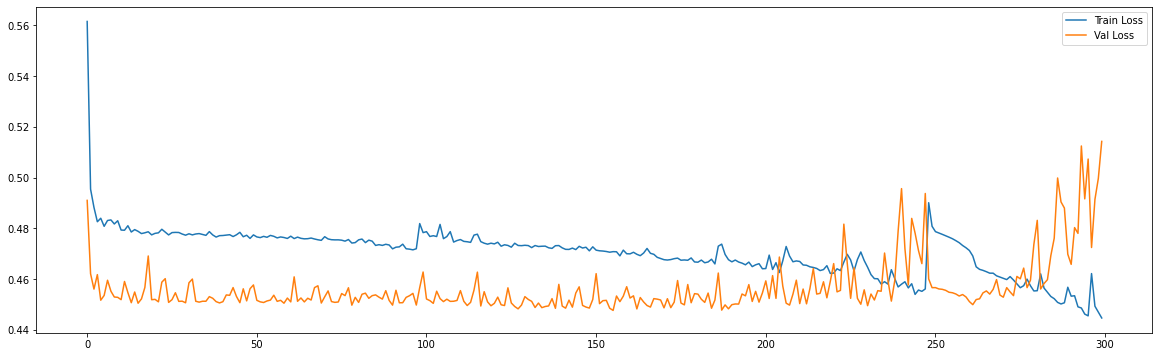

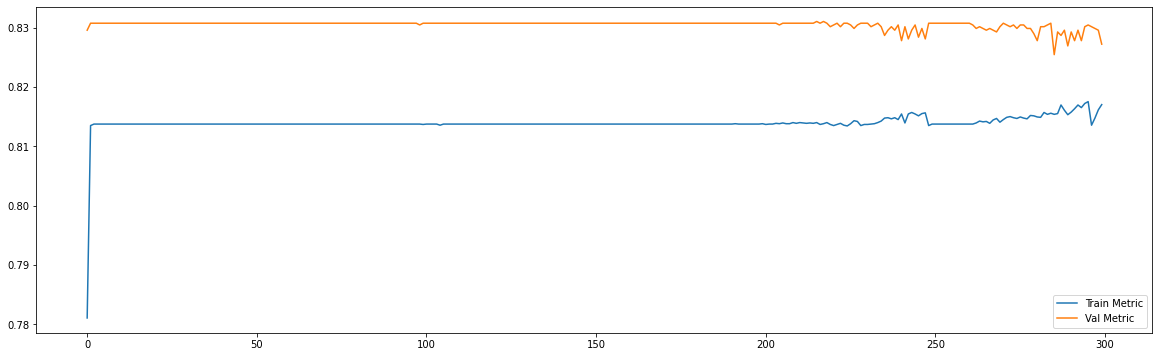



496/496 [==============================] - 3s 5ms/step - loss: 0.4413 - accuracy: 0.8177
loss and metric train data [0.4413154125213623, 0.8177056908607483]
107/107 [==============================] - 1s 5ms/step - loss: 0.5142 - accuracy: 0.8272
loss and metric val data [0.5142297744750977, 0.8272004723548889]
107/107 [==============================] - 1s 5ms/step - loss: 0.4865 - accuracy: 0.8277
loss and metric test data [0.48645704984664917, 0.8277385234832764]


In [23]:
regressor = Sequential()
regressor.add(LSTM(units=80, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dense(units=1))

adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = regressor.fit(x_train_norm, y_train, validation_data=(x_val_norm,y_val), epochs = 300, batch_size=60, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train_norm,y_train))
print('loss and metric val data',regressor.evaluate(x_val_norm,y_val))
print('loss and metric test data',regressor.evaluate(x_test_norm,y_test))

# Dropout

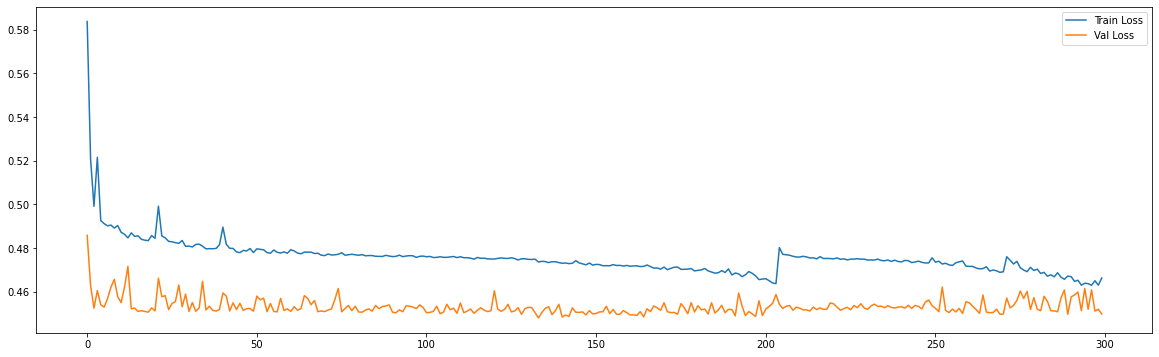

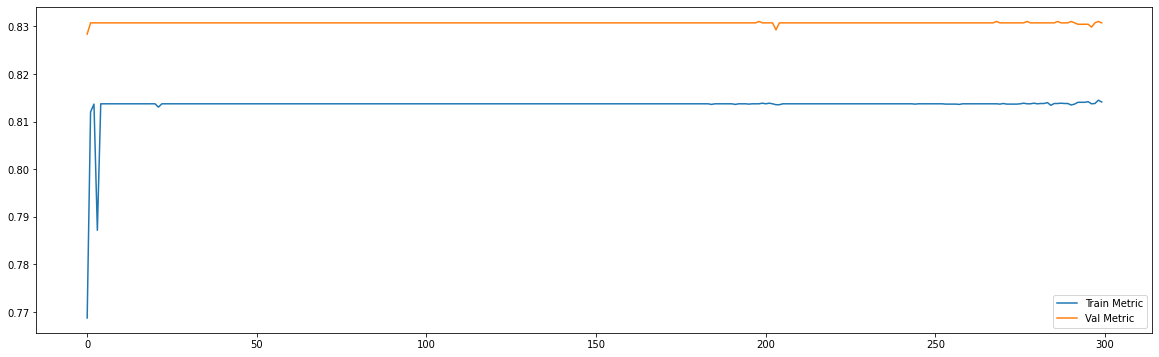



496/496 [==============================] - 2s 5ms/step - loss: 0.4733 - accuracy: 0.8137
loss and metric train data [0.47325149178504944, 0.8137304186820984]
107/107 [==============================] - 0s 5ms/step - loss: 0.4499 - accuracy: 0.8307
loss and metric val data [0.44985541701316833, 0.8307330012321472]
107/107 [==============================] - 0s 5ms/step - loss: 0.4571 - accuracy: 0.8310
loss and metric test data [0.4571283161640167, 0.8309776186943054]


In [24]:
regressor = Sequential()
regressor.add(LSTM(units=80, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = regressor.fit(x_train_norm, y_train, validation_data=(x_val_norm,y_val), epochs = 300, batch_size=60, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train_norm,y_train))
print('loss and metric val data',regressor.evaluate(x_val_norm,y_val))
print('loss and metric test data',regressor.evaluate(x_test_norm,y_test))

# Conclusion

Despite the lack of text pre-processing the performance of the RNN was not terrible.

For a real application it's necessary to preprocess the text, it's the most important and difficult part of a NLP project and must be done (like in the Bag of Words approach).

Generate new features based on the text could help in the performance too, like Part-of-speech tagging.

All this stuff will be implemented in a close feature, in this notebooks or others.
